In [19]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
# from scipy import stats
# import missingno as msno
from datetime import datetime

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import warnings
# pd.options.mode.chained_assignment = None
# warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [20]:
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import minmax_scale
# from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn import preprocessing as skp 
from sklearn.preprocessing.data import QuantileTransformer
from sklearn.preprocessing import FunctionTransformer
import xgboost as xg
from sklearn.linear_model import LogisticRegression



# Kaggle's Bike Sharing Demand 

## Overview

## Introduction

### Original Features
- datetime - hourly date + timestamp  
- season - 
    - 1 = spring
    - 2 = summer
    - 3 = fall 
    - 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

## Basic Analysis
* histogram the data
* create feature correlation heatmap
* add time features (year,year-month,month,week_number,day_of_week,day,hour)
* use log transformer 
* test increase demand year-over-year, month-over-month,

## Feature Ingeneering
* use desicision tree to convert hours into bins
* use desicision tree to convert temps into bins
* create dummy variables
* seperate data to casual and registered



### Sources
our challange:
* https://www.analyticsvidhya.com/blog/2015/06/solution-kaggle-competition-bike-sharing-demand/
* https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile
* https://www.kaggle.com/miteshyadav/comprehensive-eda-with-xgboost-top-10-percentile

How to use XGBoost:
* For Dummies - https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/
* http://nbviewer.jupyter.org/github/jmsteinw/Notebooks/blob/master/XG_Boost_NB.ipynb
* https://github.com/dmlc/xgboost/blob/master/doc/parameter.md


Trasnformers for inbalanced data:
http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html


# Get the data



In [21]:
ods_bike_raw = pd.read_csv('C:\\Users\\Roy\\Dropbox\\GitHub\\Final Project\\source_files\\train.csv')
# ods_bike_raw = pd.read_csv('C:\\Users\\roy.leiser\\Dropbox\\GitHub\\Final Project\\source_files\\train.csv')
ods_bike = ods_bike_raw.copy()
ods_bike.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [22]:
target_columns = ['casual', 'registered', 'count']

# Feature Engineering 



In [23]:
def round_fractions(data):
    data['atemp_round'] = data['atemp'].apply(round)
    data['temp_round'] = data['temp'].apply(round)
    data['windspeed_round'] = data['windspeed'].apply(round)

In [24]:
def get_fractions(df):
    return df[['temp','atemp','windspeed']]

In [25]:
def add_time_measures(df):
#     Convert df.datetime to datetime:
    try:
        df['datetime']=df['datetime'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
    except TypeError:
        pass
#     add various time measures:
    df['year'] = df['datetime'].apply(lambda x: x.date().year)
    df['month'] = df['datetime'].apply(lambda x: x.date().month)
    df['weekday'] = df['datetime'].apply(lambda x: x.date().weekday())
    df['day'] = df['datetime'].apply(lambda x: x.date().day)
    df['hour'] = df['datetime'].apply(lambda x: x.time().hour)   

In [26]:
def drop_dateime(df):
    del df['datetime']

In [27]:
drop_dateime_transformer = FunctionTransformer(func=drop_dateime, validate=False)
add_time_measures_transformer = FunctionTransformer(func=add_time_measures, validate=False)
get_fractions_transformer = FunctionTransformer(func=get_fractions, validate=False)
round_transformer = FunctionTransformer(func=round, validate=False)

fraction_pipeline = Pipeline([('get_fractions_transformer',get_fractions_transformer),('round_transformer',round_transformer)])

In [28]:
def add_is_weekend(df):
    df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x in [0,1] else 0)    
# True if x % 2 == 0 else False
    
add_is_weekend_transformer = FunctionTransformer(func=add_is_weekend, validate=False)

In [29]:
def remove_windspeed_outliers(df):
        df['windspeed'] = df['windspeed'].apply(lambda x: x if x < 40 else 40)
        df['windspeed_round'] = df['windspeed_round'].apply(lambda x: x if x < 40 else 40)
        
remove_windspeed_outliers_transformer = FunctionTransformer(func=remove_windspeed_outliers, validate=False)

In [30]:
def convert_to_single_target_column(df):
    df_casual = df.copy()
    df_casual['is_casual'] = 1
    df_casual['target'] = df_casual['casual']
    df_casual.drop(['registered','casual','count'], axis=1, inplace=True)
    
    df_registered = df.copy()
    df_registered['is_casual'] = 0
    df_registered['target'] = df_registered['registered']
    df_registered.drop(['registered','casual','count'], axis=1, inplace=True)
    
    return pd.concat([df_casual,df_registered],ignore_index=True)
    

In [31]:
def convert_to_triple_target_column(df):
    df_casual = df[df.is_casual == 1].copy()
    df_casual['casual'] = df_casual['target']
    df_casual.drop(['target','is_casual'], axis=1, inplace=True)
    
    df_registered = df[df.is_casual == 0].copy()
    df_registered['registered'] = df_registered['target']
    df_registered.drop(['target','is_casual'], axis=1, inplace=True)
    
    df_new = pd.merge(df_casual,df_registered,on= ['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed'])
    df_new['count'] = df_new['casual'] + df_new['registered']
     
    return df_new

In [32]:
tmp_ods_bike = ods_bike.copy()
tmp_ods_bike.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [33]:
# def get_target_cols(df):
#     return df[['casual', 'registered', 'count']]

# targets_selector = FunctionTransformer(func=get_target_cols, validate=False)

In [34]:
log1p_transformer = FunctionTransformer(np.log1p)                                   
quant_transformer = QuantileTransformer(output_distribution='normal')
robust_transformer = RobustScaler()
norm_transformer = Normalizer()




## Converting Hour to bins in dummy variables?

# Model Preperations
### RMSLE Scorer

In [35]:
def rmsle(y_test, y_pred): 
    return np.sqrt(np.square(np.log(y_test + 1) - np.log(y_pred + 1)).mean())

# Model Preperations
### Define Classifiers

In [36]:
# Define classifiers
clf_LR = LogisticRegression()
clf_DT = DecisionTreeClassifier(max_depth=300,
                                min_samples_split=10,
                                min_samples_leaf=10)
clf_XGR = xg.XGBRegressor()
clf_XGC = xg.XGBClassifier()

# The Model
### Preparing the data

In [37]:
# duplicate the dataset:
dwh_bike = ods_bike.copy()

# dwh_bike.head(2)

In [38]:
dwh_bike = convert_to_single_target_column(dwh_bike)
# dwh_bike.head()

In [39]:
round_fractions(dwh_bike)
add_time_measures(dwh_bike)
drop_dateime(dwh_bike)
remove_windspeed_outliers(dwh_bike)
# dwh_bike.head(2)

In [40]:
# apply log1p on target variables.
# dwh_bike[target_columns] = quant_transformer.fit_transform(dwh_bike[target_columns])
# dwh_bike[target_columns] = log1p_transformer.fit_transform(dwh_bike[target_columns])
dwh_bike['target'] = dwh_bike['target'].apply(np.log1p)
dwh_bike.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,is_casual,target,atemp_round,temp_round,windspeed_round,year,month,weekday,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,1,1.386294,14,10,0,2011,1,5,1,0
1,1,0,0,1,9.02,13.635,80,0.0,1,2.197225,14,9,0,2011,1,5,1,1


# Run the model

In [41]:
# Split the data
X = dwh_bike.drop('target',axis=1)
# y = dwh_bike['count']
y = dwh_bike['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [42]:
full_pipeline = Pipeline([
#                        ('add_time_measures',add_time_measures_transformer),
#                        ('drop_dateime',drop_dateime_transformer),
#                        ('is_weekend',add_is_weekend_transformer)
                         ('XGRegressor',clf_XGR)
                        ])

In [43]:
# Cross Validation 
k = 5
scores = cross_val_score(full_pipeline,X_train, y_train, cv=k)

print ("Scores : " + (k * "{:.3f} ").format(*scores))
print ("Average:", scores.mean())

Scores : 0.901 0.889 0.894 0.890 0.897 
Average: 0.894302588426


In [44]:
full_pipeline.fit(X_train,y_train)
y_pred = full_pipeline.predict(X_test)

In [45]:

X_test['target'] = y_pred
X_test['datetime'] = pd.to_datetime(X_test[['year', 'month', 'day', 'hour']])
X_test = convert_to_triple_target_column(X_test)
y_pred_new = X_test['count']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
rmsle(np.expm1(y_test),np.expm1(y_pred_new))

6.531580318055231

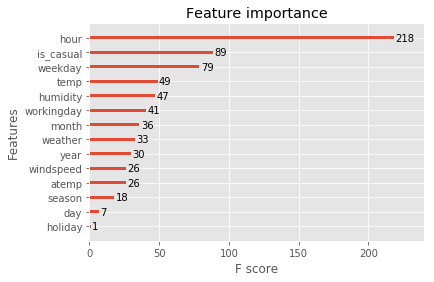

In [47]:
plt.style.use('ggplot') 
xg.plot_importance(clf_XGR)

# # plt.style.use('ggplot') 
# xgb.plot_importance(bst) 

# xgb.to_graphviz(clf_XGR, num_trees=2)

    